In [195]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
import math
import json

In [196]:
cards_csv = pd.read_csv('../dataset/cards.csv', sep=";")
prices_csv = pd.read_csv('../dataset/cardPrices.csv', sep=",")

# perform inner join based on UUID, then drop null values
all_data = pd.merge(prices_csv, cards_csv, on="uuid")
print(f"Number of NA values: \n{all_data.isnull().sum()} \n")

all_data.dropna(inplace=True)
data = all_data.reset_index(drop=True)

print(f"Dtypes: \n{data.dtypes.value_counts()}\n")
print(f"Combined dataset by uuid (all cards with prices) size: {len(data)}")


Number of NA values: 
cardFinish               0
currency                 0
date                     0
gameAvailability         0
price                    0
priceProvider            0
providerListing          0
uuid                     0
artist                  61
colorIdentity        59019
colors              113894
edhrecRank           29930
edhrecSaltiness     148222
finishes                 0
hasFoil                  0
hasNonFoil               0
isReprint           283165
language                 0
layout                   0
manaCost             65666
manaValue                0
name                     0
number                   0
originalType        152028
power               286902
rarity                   0
setCode                  0
sourceProducts       50773
supertypes          465888
toughness           286902
type                     0
types                    0
dtype: int64 

Dtypes: 
object     26
float64     4
bool        2
Name: count, dtype: int64

Combined dataset by u

## Quantitative Data Analysis

In [197]:
# Analyze quantitative data columns
quantitative = data.select_dtypes(include=['number'])

print(quantitative.describe())

             price    edhrecRank  edhrecSaltiness    manaValue
count  7947.000000   7947.000000      7947.000000  7947.000000
mean      3.536902   4569.391343         0.534512     4.628917
std       9.675474   4039.917543         0.412118     1.750793
min       0.010000    211.000000         0.030000     1.000000
25%       0.280000   1583.000000         0.250000     3.000000
50%       0.790000   3377.000000         0.400000     4.000000
75%       3.000000   6435.000000         0.730000     6.000000
max     286.290000  25319.000000         2.550000    12.000000


In [198]:
# plot function 

def plot(data, type, color=plt.cm.viridis(0.2), bins=None, lim=None):
    """Creates plots for the quantitative DataFrame
    Args:
        - data: dataframe
        - type: type of plot (hist, box)
        - color: plot color
        - bins: number of bins in this hist
        - lim: optional bound for graph
    """
    # subplot calcuations for size
    num = len(data.columns)
    ncols = 2
    nrows = int(np.ceil(num / ncols))

    # size based on nrows
    plt.figure(figsize=(12, 5*nrows))

    for i, column in enumerate(data.columns):      
        plt.subplot(nrows,ncols,i+1)
        if type == "hist":
            plt.hist(data[column], color = color, bins=bins)
            plt.title(f"Histogram of {column}")
            plt.ylabel("Frequency")
            plt.xlabel("Value")
            if lim:
                plt.title(f"Histogram of {column} bounded under {lim}")
                plt.xlim(0,lim)
        elif type == "box":
            if bins == 2 and column != "price":
                sns.boxplot(x = column, y = "price", data = data)
                plt.ylabel("price")
            else:
                plt.boxplot(data[column], whis=lim, patch_artist=True)
                plt.ylabel("Value")
            plt.title(f"Box Plot of {column}")
            if lim:
                plt.ylim(0,lim)
    plt.show()

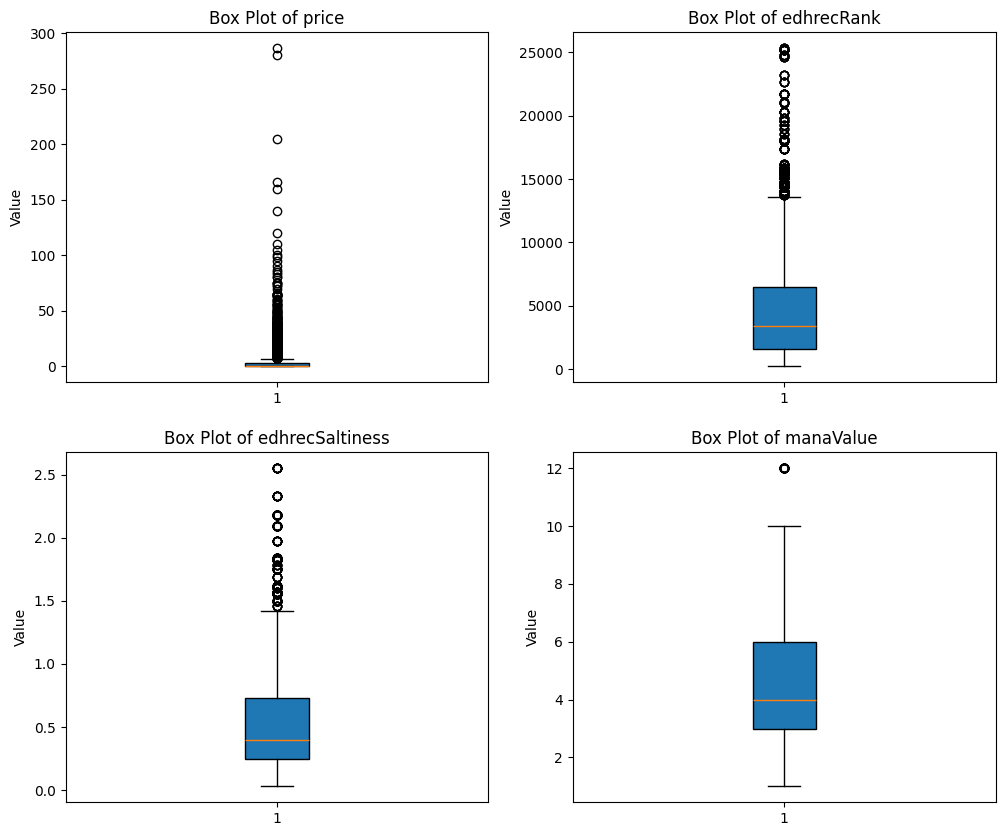

In [199]:
plot(quantitative, "box")

By Empirical Rule 99.7% of the price values should be below 32.56332335464345. 
So below is the adjusted graph for Prices to show 99.7% of the data.


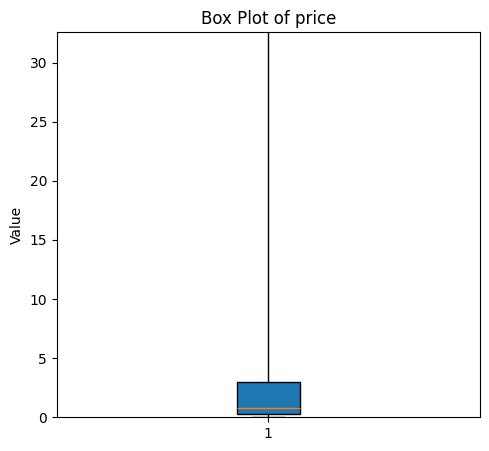

In [200]:
upper_third_std = quantitative["price"].mean() + (3 * quantitative["price"].std())
print(f"By Empirical Rule 99.7% of the price values should be below {upper_third_std}. \nSo below is the adjusted graph for Prices to show 99.7% of the data.")

plot(quantitative[["price"]], "box", lim=upper_third_std)

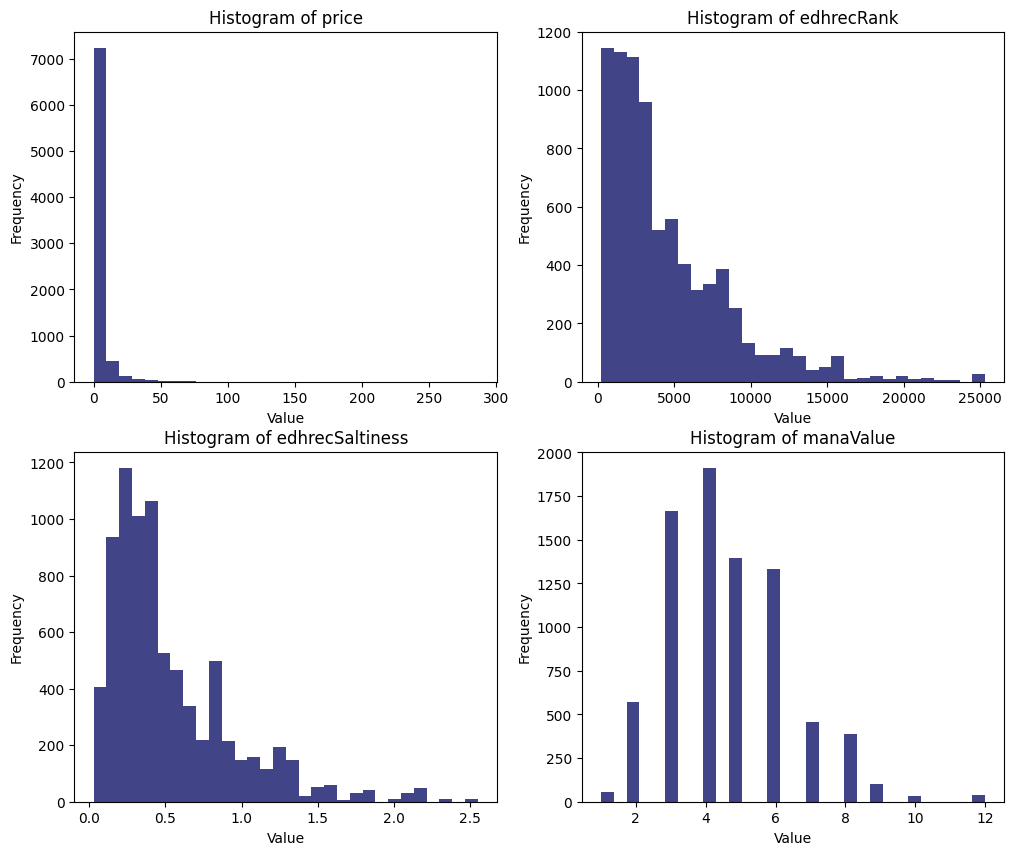

In [201]:
plot(quantitative, "hist", bins=30)

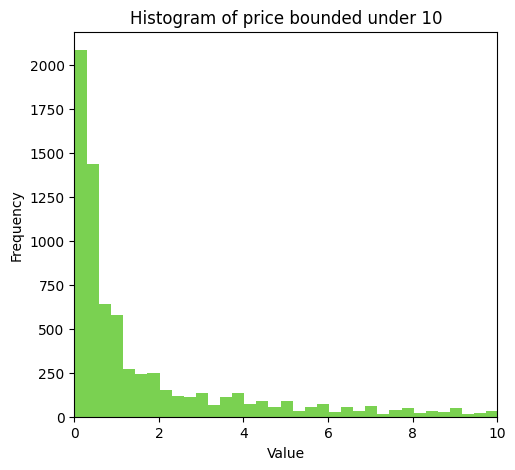

In [202]:
plot(quantitative[["price"]], "hist", plt.cm.viridis(0.8), bins=1000, lim=10)

In [203]:
# Correlations
def corr(data):
    """Plot correlation between variables in a dataframe
    Args:
        - data: dataframe
    """
    correlation_matrix = data.corr()
    
    # get price to be the first variable
    ordered = ['price'] + [col for col in correlation_matrix.columns if col != 'price']
    ordered_correlation_matrix = correlation_matrix.loc[ordered, ordered]

    plt.figure(figsize=(10,8))
    sns.heatmap(ordered_correlation_matrix, annot=True, fmt='.2f', cmap='cividis', square=True, linewidths=0.5)
    plt.title("Correlation Heatmap of Variables")
    plt.show()

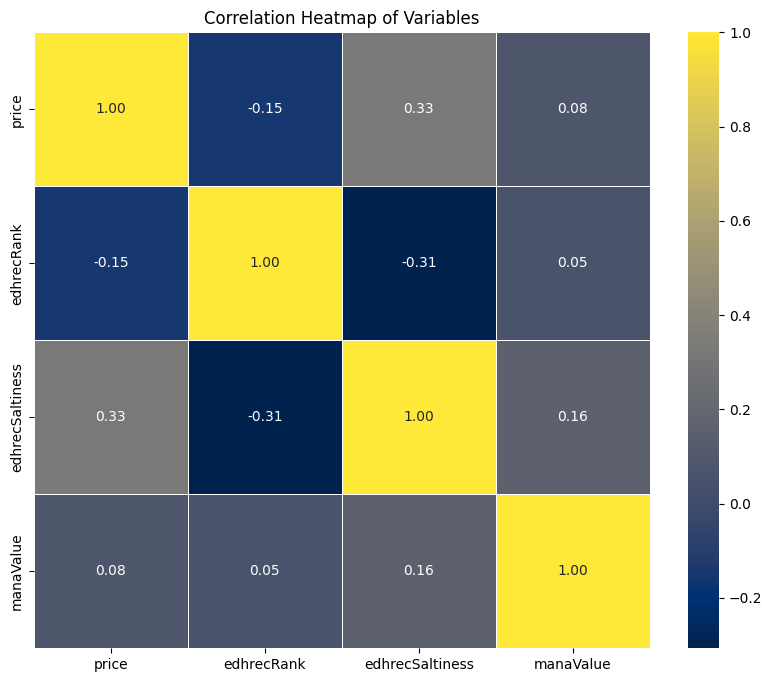

In [204]:
corr(quantitative)

#### Corellation Coefficient Interpretations

- Price vs EdhrecRank (-0.15): weak negative correlation. Very slight tendency for higher EdhrecRanks to be associated with lower prices
- Price vs EdhrecSaltiness (0.33): moderate positive correlation. As price increases, the edhrecSaltiness also tends to increase
- Price vs ManaValue (0.08): Week positive correlation. Almost no relationship, no significat influence on the price

## Categorical Data Analysis

In [205]:
# Get unique counts for qualitative variables

unique_counts = {}
binary_data = pd.DataFrame()
mapped_cat = {}
extra_cat = pd.DataFrame()

for column in data.columns:
    count = data[column].nunique()
    unique = data[column].unique()

    unique_counts[column] = {
        "Unique Counts": count,
        "Counts": data[column].value_counts().to_dict()
    }
    if count == 2:
        mapping = {unique[0]: 1, unique[1]: 0}
        binary_data[column] = data[column].map(mapping)
        mapped_cat[column] = mapping
    else:
        if column in quantitative:
            # skip quantiative columns for the binary_data
            continue
        else:
            # number of columns that have more than 2 unique values (TODO one-hot encoding)
            extra_cat[column] = data[column]



unique_df = pd.DataFrame(unique_counts).T

print(f"Initial evaluation of unique data. \n{unique_df}\n")
print(f"Mapped Categories: {mapped_cat}\n")
print(f"Binary Categories: {binary_data}")

Initial evaluation of unique data. 
                 Unique Counts  \
cardFinish                   3   
currency                     2   
date                         1   
gameAvailability             2   
price                     1193   
priceProvider                5   
providerListing              2   
uuid                      1208   
artist                     251   
colorIdentity               28   
colors                      28   
edhrecRank                 629   
edhrecSaltiness            127   
finishes                     4   
hasFoil                      2   
hasNonFoil                   2   
isReprint                    1   
language                     1   
layout                       4   
manaCost                   222   
manaValue                   11   
name                       552   
number                     549   
originalType               258   
power                       13   
rarity                       5   
setCode                     95   
sourceProduc

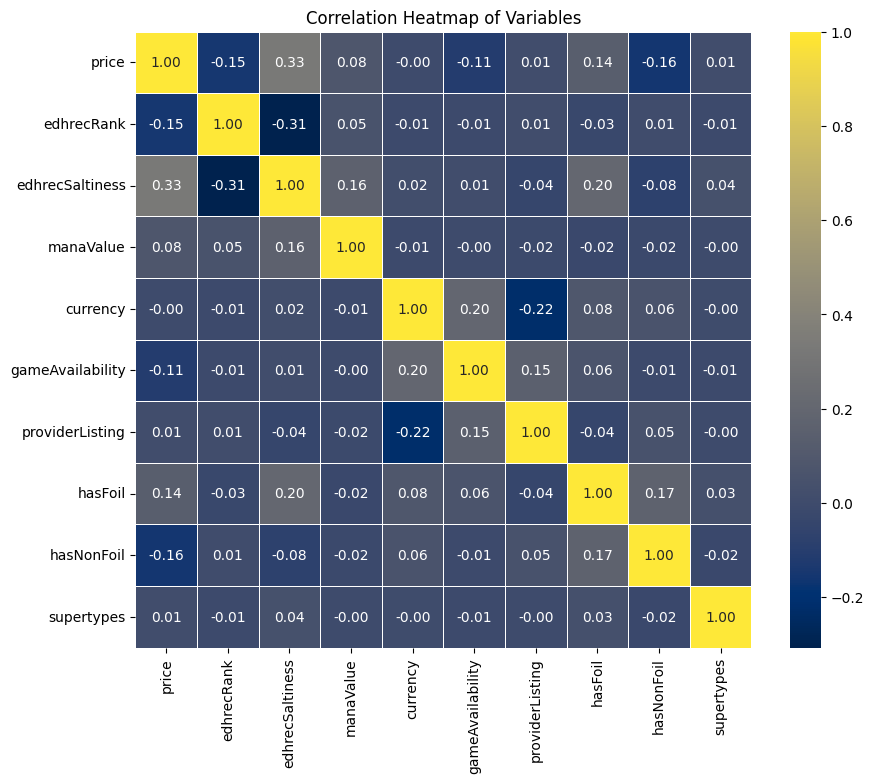

In [206]:
# add dataframes together horizontally
mapped_data = pd.concat([quantitative, binary_data], axis=1)

corr(mapped_data)

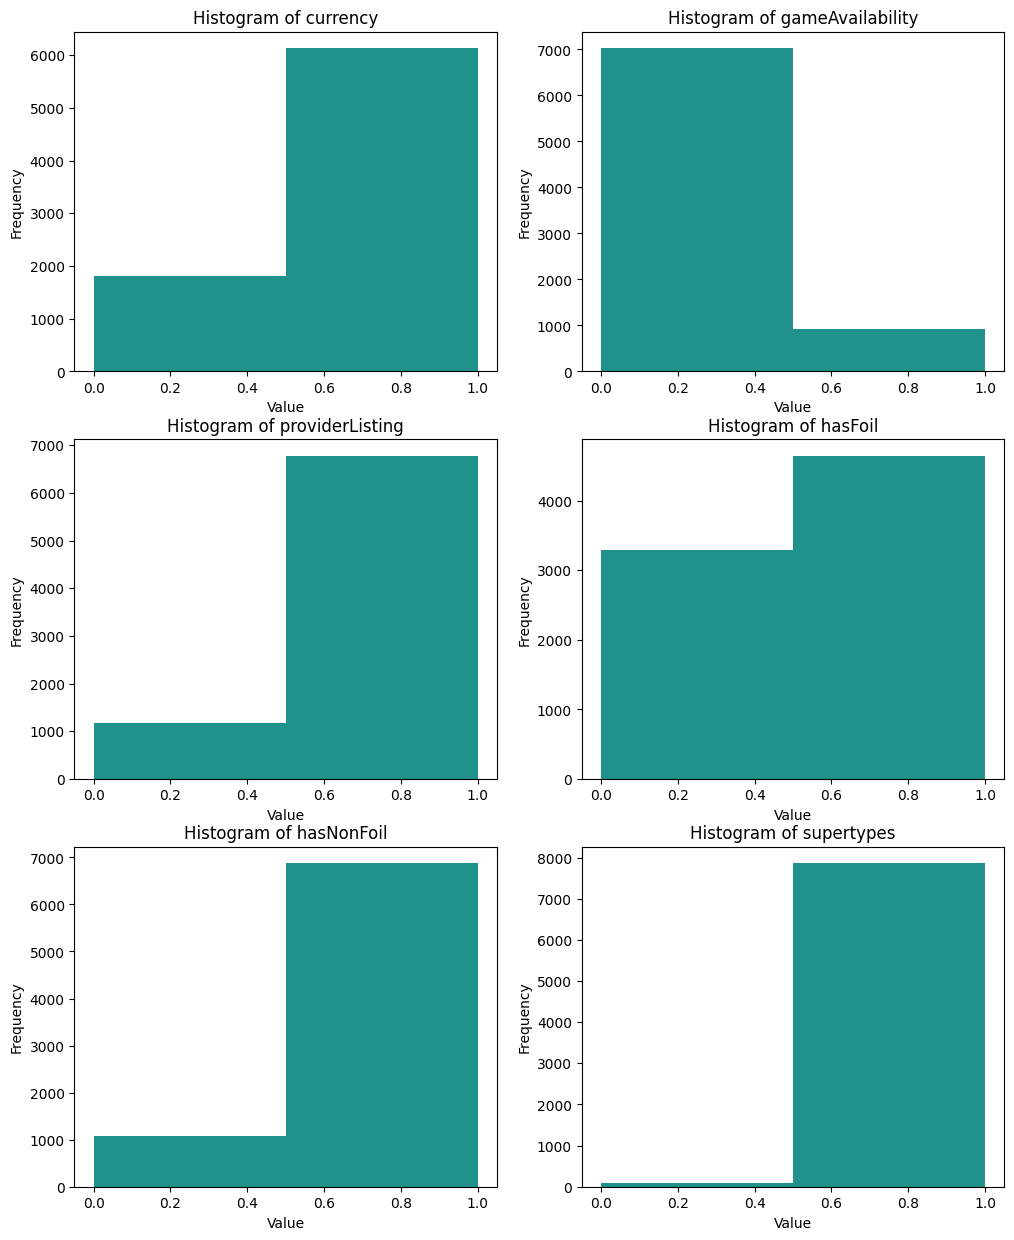

In [207]:
plot(binary_data, "hist", color=plt.cm.viridis(0.5), bins=2)

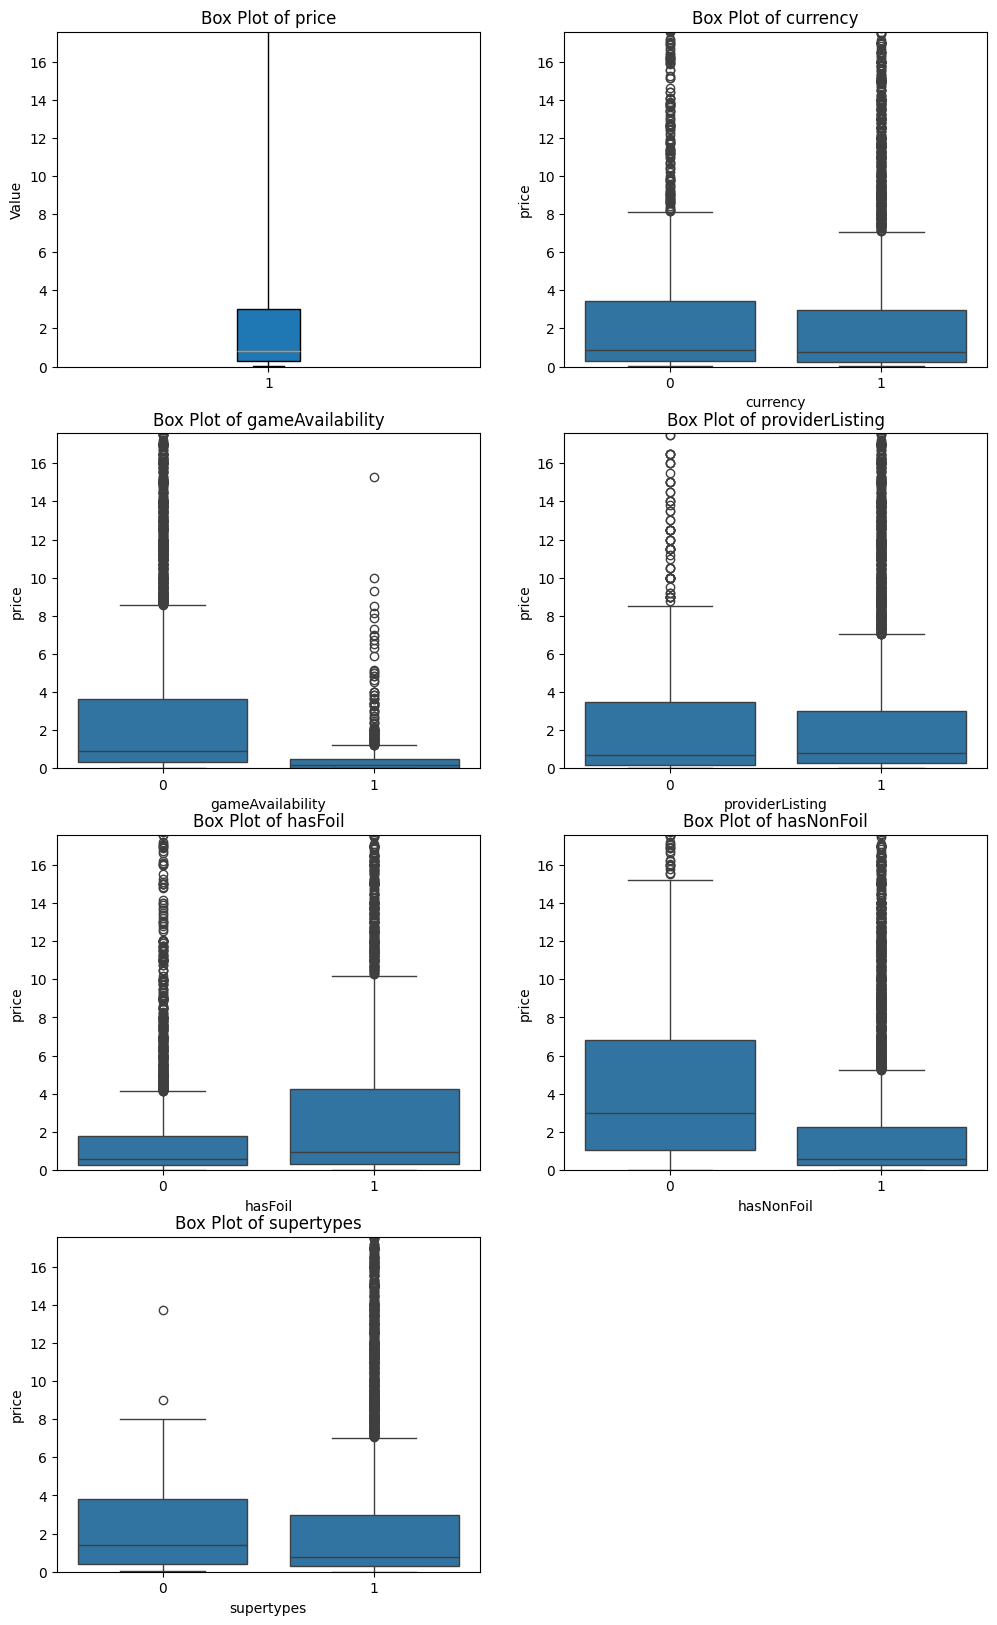

In [211]:
# Show all binary categories by price on a boxplot

plot(mapped_data.drop(columns=["edhrecRank", "edhrecSaltiness", "manaValue"]), "box", color=plt.cm.viridis(0.5), bins=2, lim=upper_third_std-15)

In [215]:
print(mapped_data.head())

# TODO fix this variable export so we dont have to save out variables to then use in other files

# __all__ = ['mapped_data']

mapped_data.to_csv('../dataset/mapped_data.csv', index=False)

   price  edhrecRank  edhrecSaltiness  manaValue  currency  gameAvailability  \
0   0.02      9476.0             0.84        8.0         1                 1   
1   0.03      9476.0             0.84        8.0         1                 1   
2   1.87      9476.0             0.84        8.0         1                 0   
3  29.16      9476.0             0.84        8.0         1                 0   
4   0.91      9476.0             0.84        8.0         0                 0   

   providerListing  hasFoil  hasNonFoil  supertypes  
0                1        1           1           1  
1                1        1           1           1  
2                1        1           1           1  
3                1        1           1           1  
4                1        1           1           1  


In [210]:
# TODO one-hot encoding or some type of encoding for categorical variables

print(f"Num of Categories that have more than 2 unique values: {extra_cat.columns}")

Num of Categories that have more than 2 unique values: Index(['cardFinish', 'date', 'priceProvider', 'uuid', 'artist',
       'colorIdentity', 'colors', 'finishes', 'isReprint', 'language',
       'layout', 'manaCost', 'name', 'number', 'originalType', 'power',
       'rarity', 'setCode', 'sourceProducts', 'toughness', 'type', 'types'],
      dtype='object')
